In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
building_data = pd.read_parquet("//Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/MA_baseline_metadata_and_annual_results.parquet")

# Heating

In [4]:
col_list = [
    "in.heating_setpoint",
    "in.heating_setpoint_has_offset",
    "in.heating_setpoint_offset_magnitude",
    "in.heating_setpoint_offset_period",
]

heating_data = building_data[col_list]

In [6]:
def generate_building_schedule(mode: str, building_id: int, building_data: pd.DataFrame) -> np.ndarray:
    """Generates a building's heating setpoint offset schedule

    Args:
        mode (str): Either heating or cooling
        building_id (int): ID of the building
        building_data (pd.DataFrame): Heating setpoint dataset

    Returns:
        np.ndarray: Building's heating schedule during the day (when to apply offset)
    """
    building_data = building_data[building_data.index == building_id]

    night_start = 22
    night_end = 7

    day_start = 9
    day_end = 17

    schedule = np.zeros(24)

    has_offset = "in.heating_setpoint_has_offset" if mode == "heating" else "in.cooling_setpoint_has_offset"
    offset_magnitude = "in.heating_setpoint_offset_magnitude" if mode == "heating" else "in.cooling_setpoint_offset_magnitude"
    offset_period = "in.heating_setpoint_offset_period" if mode == "heating" else "in.cooling_setpoint_offset_period"

    if building_data[has_offset].item() == "Yes":
        offset_magnitude = int(building_data[offset_magnitude].item().replace("F", ""))
        offset_period = building_data[offset_period].item()

        if offset_period[-1] == "h":
            offset_period_number = int(offset_period[-3:-1])
        else:
            offset_period_number = 0

        

        if "Night" in offset_period:
            night_start += offset_period_number
            night_end += offset_period_number

            if night_start > night_end:
                schedule[night_start:] = 1
                schedule[:night_end] = 1
            else:
                schedule[night_start:night_end] = 1

        if "Day" in offset_period:
            day_start += offset_period_number
            day_end += offset_period_number

            if day_start > day_end:
                schedule[day_start:] = 1
                schedule[:day_end] = 1
            else:
                schedule[day_start:day_end] = 1

        schedule *= offset_magnitude

    return schedule


In [7]:
def generate_building_setpoint_timeseries(mode: str, building_id: int, building_data: pd.DataFrame) -> pd.DataFrame:
    """Generates a building's heating setpoint timeseries

    Args:
        mode (str): Either heating or cooling
        building_id (int): ID of the building
        building_data (pd.DataFrame): Heating setpoint dataset

    Returns:
        pd.DataFrame: Building's heating setpoint timeseries
    """
    building_data = building_data[building_data.index == building_id]

    setpoint = "in.heating_setpoint" if mode == "heating" else "in.cooling_setpoint"

    # Generate empty timeseries for a full year (2018)
    timeseries = pd.date_range(start="2018-01-01", end="2018-12-31", freq="h")
    timeseries = pd.DataFrame(timeseries, columns=["timestamp"])
    timeseries["setpoint"] = int(building_data[setpoint].item().replace("F", ""))

    schedule = generate_building_schedule(mode, building_id, building_data)

    def apply_offset(row, schedule):
        hour = row["timestamp"].hour
        return row["setpoint"] + schedule[hour]
    
    timeseries["setpoint"] = timeseries.apply(apply_offset, axis=1, schedule=schedule)

    return timeseries

    

In [93]:
full_heating_timeseries_dataset = {}
for i in range(len(heating_data)):
    print(f"Processing building {i}/{len(heating_data)}           ", end="\r")
    building_timeseries = generate_building_setpoint_timeseries("heating", heating_data.index[i], heating_data)
    building_timeseries.set_index("timestamp", inplace=True)
    full_heating_timeseries_dataset[heating_data.index[i]] = building_timeseries

# Cooling

In [9]:
col_list = [
    "in.cooling_setpoint",
    "in.cooling_setpoint_has_offset",
    "in.cooling_setpoint_offset_magnitude",
    "in.cooling_setpoint_offset_period",
]

cooling_data = building_data[col_list]

In [94]:
full_cooling_timeseries_dataset = {}
for i in range(len(cooling_data)):
    print(f"Processing building {i}/{len(cooling_data)}           ", end="\r")
    building_timeseries = generate_building_setpoint_timeseries("cooling", cooling_data.index[i], cooling_data)
    building_timeseries.set_index("timestamp", inplace=True)
    full_cooling_timeseries_dataset[cooling_data.index[i]] = building_timeseries

# Combine timeseries

In [96]:
heating_1 = full_heating_timeseries_dataset[341]
cooling_1 = full_cooling_timeseries_dataset[341]

In [88]:
cooling_data.head(20)

,in.cooling_setpoint,in.cooling_setpoint_has_offset,in.cooling_setpoint_offset_magnitude,in.cooling_setpoint_offset_period
bldg_id,,,,
10,65F,No,0F,None
122,70F,No,0F,None
129,75F,No,0F,None
150,68F,No,0F,None
183,80F,Yes,2F,Night Setback -5h
188,75F,No,0F,None
192,62F,Yes,5F,Day Setup +1h
197,75F,No,0F,None
225,72F,No,0F,None


In [87]:
heating_data.head(20)

,in.heating_setpoint,in.heating_setpoint_has_offset,in.heating_setpoint_offset_magnitude,in.heating_setpoint_offset_period
bldg_id,,,,
10,67F,No,0F,None
122,72F,No,0F,None
129,75F,No,0F,None
150,67F,Yes,12F,Night -2h
183,72F,No,0F,None
188,70F,No,0F,None
192,68F,Yes,12F,Night -1h
197,70F,Yes,3F,Night -3h
225,67F,No,0F,None


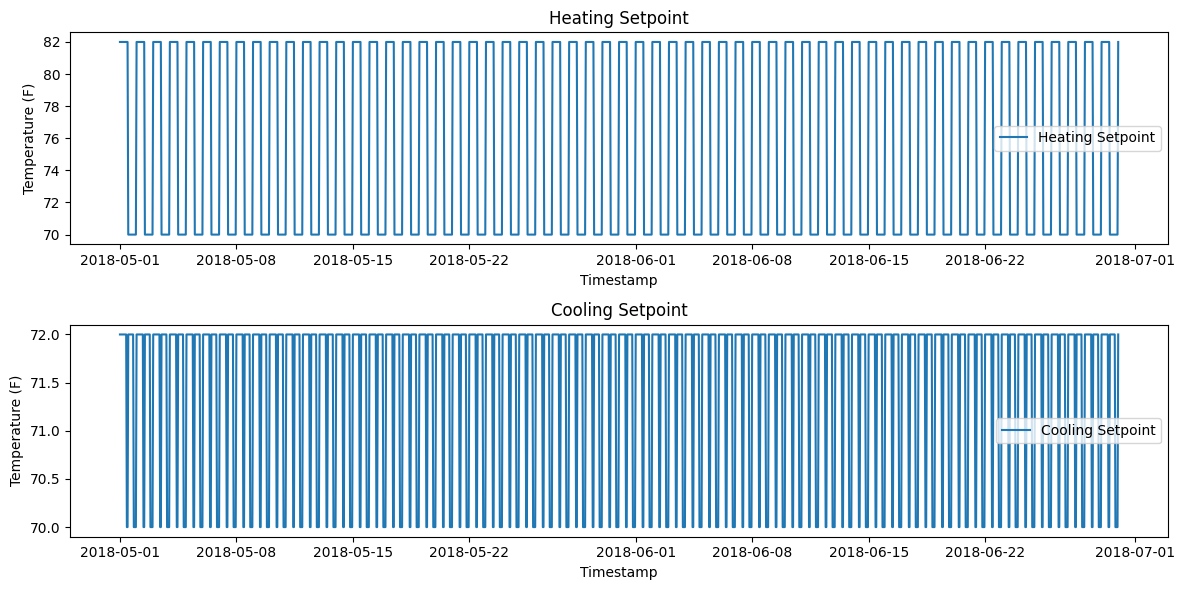

In [97]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

start_date = "2018-05-01"
end_date = "2018-06-30"
mask = (heating_1.index >= start_date) & (heating_1.index <= end_date)

ax1.plot(heating_1.index[mask], heating_1["setpoint"][mask], label="Heating Setpoint")
ax1.set_title("Heating Setpoint")

ax2.plot(cooling_1.index[mask], cooling_1["setpoint"][mask], label="Cooling Setpoint")
ax2.set_title("Cooling Setpoint")

ax1.set_xlabel("Timestamp")
ax2.set_xlabel("Timestamp")
ax1.set_ylabel("Temperature (F)")
ax2.set_ylabel("Temperature (F)")
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.show()

In [98]:
full_timeseries = heating_1.copy()

cooling_start_date = pd.to_datetime("2018-06-01")
cooling_end_date = pd.to_datetime("2018-10-31")

for i in range(len(full_timeseries)):
    if full_timeseries.index[i] >= cooling_start_date and full_timeseries.index[i] <= cooling_end_date:
        full_timeseries["setpoint"][i] = cooling_1["setpoint"][i]

/var/folders/bw/4qyc6pj92bdb1bv22yhll2zw0000gn/T/ipykernel_5813/4218854108.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  full_timeseries["setpoint"][i] = cooling_1["setpoint"][i]
/var/folders/bw/4qyc6pj92bdb1bv22yhll2zw0000gn/T/ipykernel_5813/4218854108.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "co

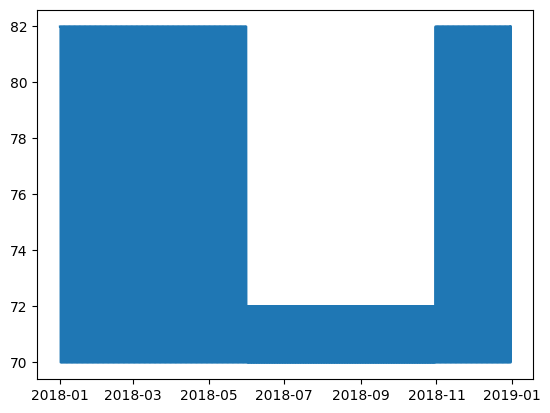

In [100]:
plt.plot(full_timeseries.index, full_timeseries["setpoint"], label="Setpoint")